# What improves a classification transformer's accuracy? 

There are [many tutorials](https://www.borealisai.com/research-blogs/tutorial-17-transformers-iii-training/) on the types of architectures that improves a Transformer's accuracy. As a personal project to learn more about transformers, I wanted to test this out for myself. Here, we'll be primarily working with [PyTorch's IMDB dataset](https://pytorch.org/text/stable/datasets.html), where we'll be classifying movie reviews as positive or negative.

A lot of the discussion here is based on previous blog posts or papers, such as [Peter Bloem's blog](http://peterbloem.nl/blog/transformers), [Kikaben](https://kikaben.com/transformers-training-details/), or [n8henrie](https://n8henrie.com/2021/08/writing-a-transformer-classifier-in-pytorch/). I also referred pretty extensively to Vaswani et al's [Attention is All You Need](https://arxiv.org/abs/1706.03762), and Coursera's [Sequence models course](https://www.coursera.org/learn/nlp-sequence-models). 

### Installing Packages and Setting up the Notebook

In [3]:
## Mounting to Google Colab
import os
from google.colab import drive
drive.mount('/content/gdrive')  
os.chdir('/content/gdrive/MyDrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Loading Libraries and Data

In [4]:
## Loading libraries

# Classic libraries
import os
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from collections import Counter
import math

# Pytorch libraries
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torchsummary import summary
import torchdata
import torchtext
from torchmetrics import Accuracy

# Torch optimizer
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim import Adam

**When running this on Jupyter Notebook/colab**, it's important to make sure the custom scripts below are on the same folder you're executing from. 

In [5]:
# Custom libraries
from classification_transformer_utils import *
from sequence_loading_utils import * 
from classification_encoders import * 

More information about data wrangling can be seen in the 3 custom library files (classification_transformer_utils and sequence_loading_utils). A series of custom neural netwok architectures can be seen in classification_encoders.

We'll be working with the IMDB movie review datasets. These are reviews for movies that have either been rated as 'pos' or 'neg'. As a quick check, we can first evaluate whether this dataset has balanced classes.

In [6]:
from torchtext.datasets import IMDB

train_data, test_data = list(IMDB(split=('train','test')))

train_class = [int(label == 'pos') for (label, line) in iter(train_data)]
test_class = [int(label == 'pos') for (label, line) in iter(test_data)]

print("Positive reviews in training dataset: ",sum(train_class)/len(train_class))
print("Positive reviews in test dataset: ",sum(test_class)/len(test_class))

Positive reviews in training dataset:  0.5
Positive reviews in test dataset:  0.5


We can see that the datasets are balanced. 

Next, we can tokenize the datasets and construct our vocab list.

In [ ]:
vocab_list, vocab_length, max_line_length, collate_batch_fn = IMDB_vocab_constructor();

In [ ]:
train_loader = data.DataLoader(list(IMDB(split=('train'))), batch_size = 32, shuffle=True, collate_fn = collate_batch_fn);
test_loader = data.DataLoader(list(IMDB(split=('test'))), batch_size = 32, shuffle=True, collate_fn = collate_batch_fn);

# Model Comparisons

### Baseline Classification Transformer

This will run a basic classification transformer. This runs the 'ClassificationEncoder' neural network defined in classification_encoders.py. We're going to assess training and test set accuracy after 100 epochs. 

Our baseline model is composed of an encoder consisting of 5 self-attention heads, with 50-dimensional embedding layer. For this initial model, we'll use a 6-layer encoder stack. For our optimizer, we're using an Adam optimizer with $\beta_β$ = 0.9, $\beta_2$ = 0.98 and $\epsilon = 10^{−9}$. Although the initial paper by Vaswani et al used varying learning rates, we'll start by trying to see how well this architecture works with a flat learnning rate (1E-4).

In [ ]:
# Hyperparameters
model = ClassificationEncoder(embedding_dim = 50, encoder_stack = 6,
                              num_heads = 5, layer_norm_epsilon = 1e-6, 
                              dropout_rate = 0.1, input_vocab_size = vocab_length, 
                              number_of_classes = 2, max_positions = max_line_length)
                              

criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                              betas = (0.9, 0.98), eps = 1.0e-9, lr = 1E-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
[model, epoch_training_loss_array,
 epoch_test_loss_array, epoch_training_accuracy_array, 
 epoch_test_accuracy_array, 
 time_for_epochs, _, _] = train_and_evaluate(model, 
                                             train_loader, 
                                             test_loader, 
                                             optimizer, 
                                             criterion,
                                             device, 
                                             scheduler = None, 
                                             epochs = 100, 
                                             verbose = True, 
                                             record_lr = False);

save_outputs(model, epoch_training_loss_array, epoch_test_loss_array, 
             epoch_training_accuracy_array, epoch_test_accuracy_array, 
             time_for_epochs, model_filename = 'regular_e5_classTransformer.ckpt', 
             data_filename = 'data_regular_e5_classTransformer.csv');

Using device:  cuda
Epoch 1/100 
Epoch training loss:  497.975
Epoch test loss:  501.191
Epoch training accuracy:  0.691
Epoch test set accuracy:  0.675
Time:  75.318
Epoch 2/100 
Epoch training loss:  492.0
Epoch test loss:  494.336
Epoch training accuracy:  0.703
Epoch test set accuracy:  0.696
Time:  150.922
Epoch 3/100 
Epoch training loss:  485.283
Epoch test loss:  490.595
Epoch training accuracy:  0.715
Epoch test set accuracy:  0.678
Time:  226.005
Epoch 4/100 
Epoch training loss:  479.022
Epoch test loss:  485.053
Epoch training accuracy:  0.72
Epoch test set accuracy:  0.705
Time:  301.282
Epoch 5/100 
Epoch training loss:  474.528
Epoch test loss:  481.328
Epoch training accuracy:  0.724
Epoch test set accuracy:  0.705
Time:  376.738
Epoch 6/100 
Epoch training loss:  470.604
Epoch test loss:  476.77
Epoch training accuracy:  0.73
Epoch test set accuracy:  0.711
Time:  452.431
Epoch 7/100 
Epoch training loss:  465.361
Epoch test loss:  473.563
Epoch training accuracy:  0.7

We can see that after 100% epochs, we achieve >90% accuracy on our training dataset, and 83.5% on our test set, which suggests our model is actually learning. However, we can also see that the test set loss fluctuates around 375-380, whereas the training set loss continues to decrease, demonstrating overfitting.

We can try to explore improvements that make our model more accurate: for instance, we can use key padding masks to ensure that the encoder ignores padding tokens. This was sugggested in the original Transformers by Vaswani et al, and might be helpful in large sequence-to-sequence models, but it's unclear how helpful this might be in classification models.

### Classification Transformer with Key Padding Masks
We're using the create_key_padding_mask function to add a padding mask to our inputs. The still runs runs the 'ClassificationEncoder' neural network defined in classification_encoders.py. We're going to assess training and test set accuracy after 100 epochs. 

In [ ]:
def create_key_padding_mask(lines,padding_value):
  # Creating key padding mask
    return(lines == padding_value);

model = ClassificationEncoder(embedding_dim = 50, encoder_stack = 6,
                              num_heads = 5, layer_norm_epsilon = 1e-6, 
                              dropout_rate = 0.1, input_vocab_size = vocab_length, 
                              number_of_classes = 2, max_positions = max_line_length,
                              padding_function = create_key_padding_mask, 
                              padding_value = vocab_list['<unk>'])
                              
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                              betas = (0.9, 0.98), eps = 1.0e-9, lr = 1E-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
[model, epoch_training_loss_array,
 epoch_test_loss_array, epoch_training_accuracy_array, 
 epoch_test_accuracy_array, 
 time_for_epochs, _, _]  = train_and_evaluate(model, 
                                             train_loader, 
                                             test_loader, 
                                             optimizer, 
                                             criterion,
                                             device, 
                                             scheduler = None, 
                                             epochs = 100, 
                                             verbose = True, 
                                             record_lr = False);

save_outputs(model, epoch_training_loss_array, epoch_test_loss_array, 
             epoch_training_accuracy_array, epoch_test_accuracy_array, 
             time_for_epochs,model_filename = 'kpv_e100_classTransformer.ckpt', 
             data_filename = 'data_kpv_e100_classTransformer.csv');

Using device:  cuda
Epoch 1/100 
Epoch training loss:  542.941
Epoch test loss:  542.97
Epoch training accuracy:  0.498
Epoch test set accuracy:  0.5
Time:  76.364
Epoch 2/100 
Epoch training loss:  540.991
Epoch test loss:  539.383
Epoch training accuracy:  0.524
Epoch test set accuracy:  0.545
Time:  152.556
Epoch 3/100 
Epoch training loss:  536.339
Epoch test loss:  536.434
Epoch training accuracy:  0.563
Epoch test set accuracy:  0.52
Time:  228.58
Epoch 4/100 
Epoch training loss:  529.912
Epoch test loss:  527.813
Epoch training accuracy:  0.599
Epoch test set accuracy:  0.618
Time:  305.185
Epoch 5/100 
Epoch training loss:  523.91
Epoch test loss:  523.281
Epoch training accuracy:  0.623
Epoch test set accuracy:  0.617
Time:  381.679
Epoch 6/100 
Epoch training loss:  517.034
Epoch test loss:  516.202
Epoch training accuracy:  0.64
Epoch test set accuracy:  0.653
Time:  457.683
Epoch 7/100 
Epoch training loss:  510.651
Epoch test loss:  512.491
Epoch training accuracy:  0.657

After 100 epochs, we can see that our training a (88.7%) and test accuracy (82.6%) is still comparable to our initial classification encoder (and in fact, decreased a bit).

We can also see how the model performs if we add more dropout layers, in an effort to prevent overfitting.

### Model with Dropout Layers

In [ ]:
model = ClassificationEncoder_dropout(embedding_dim = 50, encoder_stack = 6,
                              num_heads = 5, layer_norm_epsilon = 1e-6, 
                              dropout_rate = 0.1, input_vocab_size = vocab_length, 
                              number_of_classes = 2, max_positions = max_line_length,
                              padding_function = create_key_padding_mask, 
                              padding_value = vocab_list['<unk>'])
                              

criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                              betas = (0.9, 0.98), eps = 1.0e-9, lr = 1E-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
[model, epoch_training_loss_array,
 epoch_test_loss_array, epoch_training_accuracy_array, 
 epoch_test_accuracy_array, 
 time_for_epochs, _, _]  = train_and_evaluate(model, 
                                             train_loader, 
                                             test_loader, 
                                             optimizer, 
                                             criterion,
                                             device, 
                                             scheduler = None, 
                                             epochs = 100, 
                                             verbose = True, 
                                             record_lr = False);

save_outputs(model, epoch_training_loss_array, epoch_test_loss_array, 
             epoch_training_accuracy_array, epoch_test_accuracy_array, 
             time_for_epochs, model_filename = 'dropout_e100_classTransformer.ckpt', 
             data_filename = 'dropout_kpv_e100_classTransformer.csv');

Using device:  cuda
Epoch 1/100 
Epoch training loss:  542.817
Epoch test loss:  542.24
Epoch training accuracy:  0.499
Epoch test set accuracy:  0.5
Time:  76.576
Epoch 2/100 
Epoch training loss:  540.152
Epoch test loss:  537.593
Epoch training accuracy:  0.531
Epoch test set accuracy:  0.525
Time:  153.119
Epoch 3/100 
Epoch training loss:  533.547
Epoch test loss:  532.284
Epoch training accuracy:  0.58
Epoch test set accuracy:  0.556
Time:  230.628
Epoch 4/100 
Epoch training loss:  527.783
Epoch test loss:  525.931
Epoch training accuracy:  0.604
Epoch test set accuracy:  0.624
Time:  307.7
Epoch 5/100 
Epoch training loss:  522.847
Epoch test loss:  523.295
Epoch training accuracy:  0.624
Epoch test set accuracy:  0.602
Time:  384.315
Epoch 6/100 
Epoch training loss:  517.935
Epoch test loss:  518.009
Epoch training accuracy:  0.637
Epoch test set accuracy:  0.638
Time:  460.798
Epoch 7/100 
Epoch training loss:  511.895
Epoch test loss:  511.942
Epoch training accuracy:  0.65

Similarly, we can see that having dropout layers did not significantly reduce overfitting in our test set; we achieved 87.3% training accuracy and 80% test accuracy.

## Visualizing Results

We can further visualize some of our results here:

In [12]:
datasets = [['Baseline model','data_regular_e5_classTransformer.csv','lightblue'],
            ['With key padding values (KPV)','data_kpv_e100_classTransformer.csv','blue'],
            ['With key padding values (KPV) + dropout','dropout_kpv_e100_classTransformer.csv','teal']]

(0.0, 1.0)

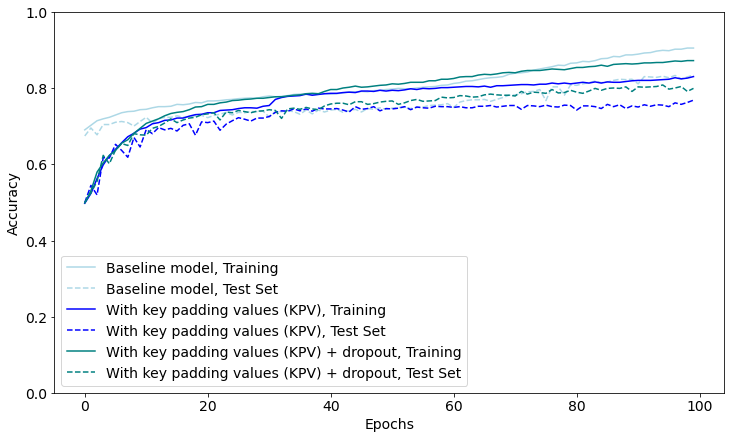

In [24]:
legend = [];

plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['font.size'] = '14'

for label, csvfile, linecolor  in datasets:

  model_data = pd.read_csv(csvfile)
  plt.plot(model_data['Training Accuracy'][0:100],'-',color=linecolor)
  plt.plot(model_data['Test Accuracy'][0:100],'--',color=linecolor)
  legend.append(label+', Training')
  legend.append(label+', Test Set')

plt.legend(legend)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.ylim([0,1])



Again, we can see that the baseline model performed best. Interestingly, the model with key padding values performed the worst, though adding dropout and key padding values seemed to improve accuracy. It might be interesting to see what happens if we have a baseline model with dropout, and no key padding values.

We can also see what happens to our loss:

Text(0.5, 0, 'Epochs')

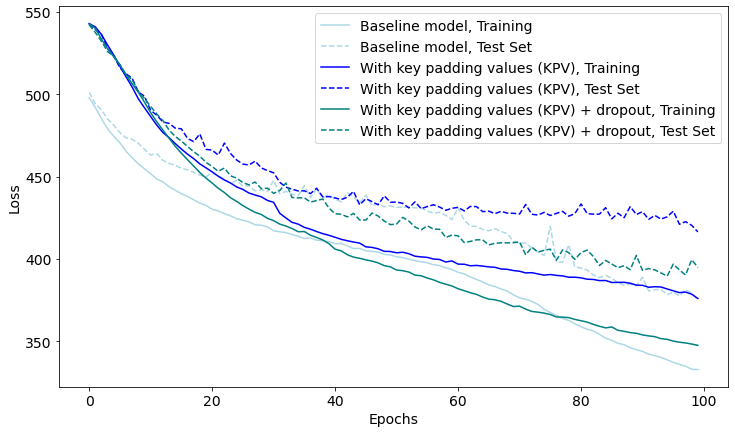

In [23]:
legend = [];

plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['font.size'] = '14'

for label, csvfile, linecolor  in datasets:

  model_data = pd.read_csv(csvfile)
  plt.plot(model_data['Training Loss'][0:100],'-',color=linecolor)
  plt.plot(model_data['Test Loss'][0:100],'--',color=linecolor)
  legend.append(label+', Training')
  legend.append(label+', Test Set')

plt.legend(legend,loc=0)
plt.ylabel('Loss')
plt.xlabel('Epochs')


We can see that by looking at the loss curves, the KPV (dark blue) is definitely overfitting. Interestingly, the baseline model still steems to be decreasing in its test set loss, suggesting that it may not be overfitting just yet. 

## Conclusions and Next Steps

We can see that a basic classification encoder, consisting of 5 attention heads and a 6-layer encoder stack, can achieve reasonable accuracy (>83.5% on the test set) in classifying movie reviews from the IMDB dataset, which suggests that the architecture is learning useful representations from the reviews. We also determined that for simple transformer networks, varying learning rates are not necessarily needed for training.

We tried to improve on this by using both key padding values and dropout layers, and neither additions improved the accuracy. However, we did see that a network with key padding values + dropout performed better than just key padding values; thus, it would be interesting to see how an architecture with no key padding values + dropout might perform. 

If we were to continue this work, some of our next steps might involve:
- Performing more systematic searches of key hyperparameters, including the number of attentionn heads and layers
- Determining how well multi-layer encoder-decoder networks can perform on similar tasks

